# Deep Neural Networks 

* Name : ____
* PRN : ___

* FileName : L01_XXX_Name

### Lecture 02
#### Implementation of Perceptron


## 1. Import Statements

In [1]:
###-----------------
### Import Libraries
###-----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections.abc import Callable

import seaborn as sns

from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
 
%matplotlib inline

## 2. Setup Global Parameters

In [2]:
###----------------
### Some parameters
###----------------

# Directory locations
inpDir = '../../input'
outDir = '../output'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 20000  # number of epochs
ALPHA = 0.1  # learning rate
N_SAMPLES = 1000
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## 3. Generate Data Set

Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.

In [3]:
x ,y = datasets.make_moons(n_samples=N_SAMPLES,
                           shuffle=True,
                           noise=NOISE,
                           random_state=RANDOM_STATE)

x.shape , y.shape

((1000, 2), (1000,))

## 4. Visualization
DataFrames are easier to visualize


In [4]:
data_df = pd.DataFrame(x,columns=['A','B'])
data_df['target'] = y
data_df

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0
...,...,...,...
995,-1.005476,0.490728,0
996,-0.484457,0.846436,0
997,0.284856,0.793560,0
998,1.712514,-0.177786,1


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   float64
 2   target  1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [6]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
A,1000.0,0.490841,0.898951,-1.688795,-0.149565,0.500100,1.095048,2.419113
B,1000.0,0.239025,0.540082,-0.955280,-0.205090,0.241163,0.680394,1.612075
target,1000.0,0.500000,0.500250,0.000000,0.000000,0.500000,1.000000,1.000000


In [7]:
data_df['target'].value_counts()

target
0    500
1    500
Name: count, dtype: int64

### 4.1 Different ways of plotting data

<Axes: xlabel='A', ylabel='B'>

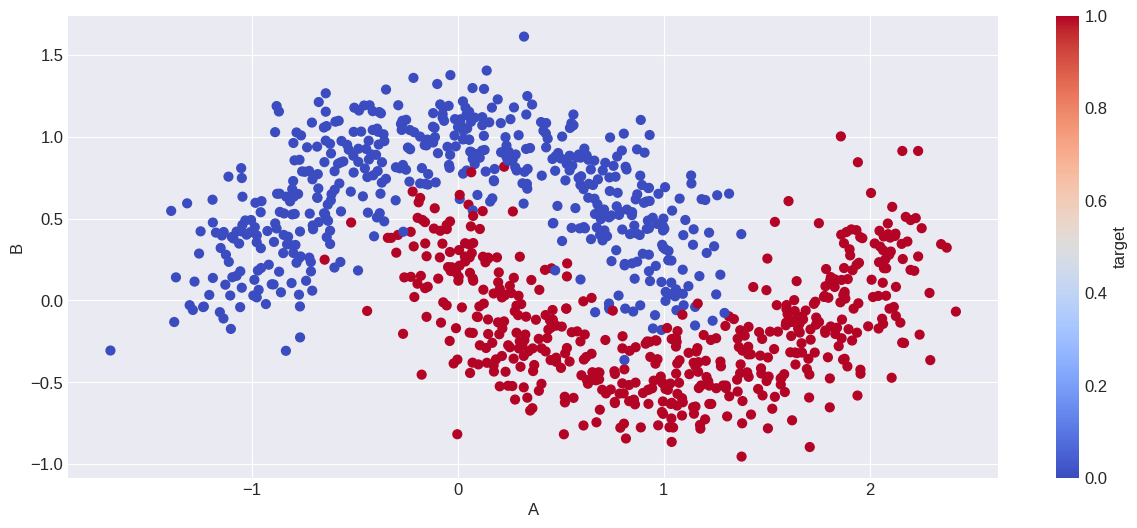

In [8]:
data_df.plot.scatter('A','B',s=40 ,c = 'target',cmap=CMAP)

<Axes: xlabel='target'>

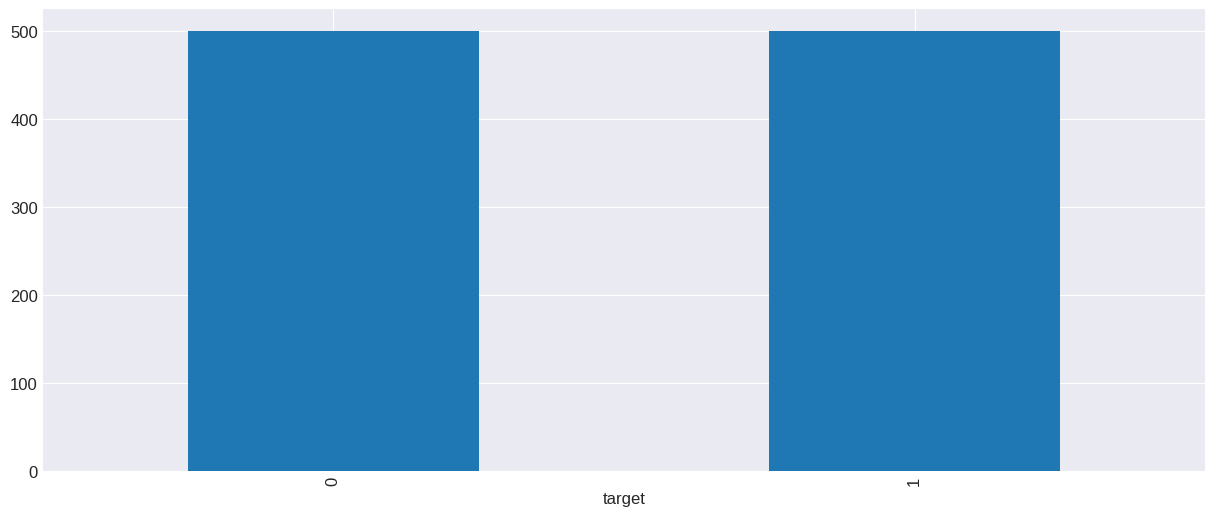

In [9]:
data_df['target'].value_counts().plot(kind='bar')

<Axes: xlabel='A', ylabel='B'>

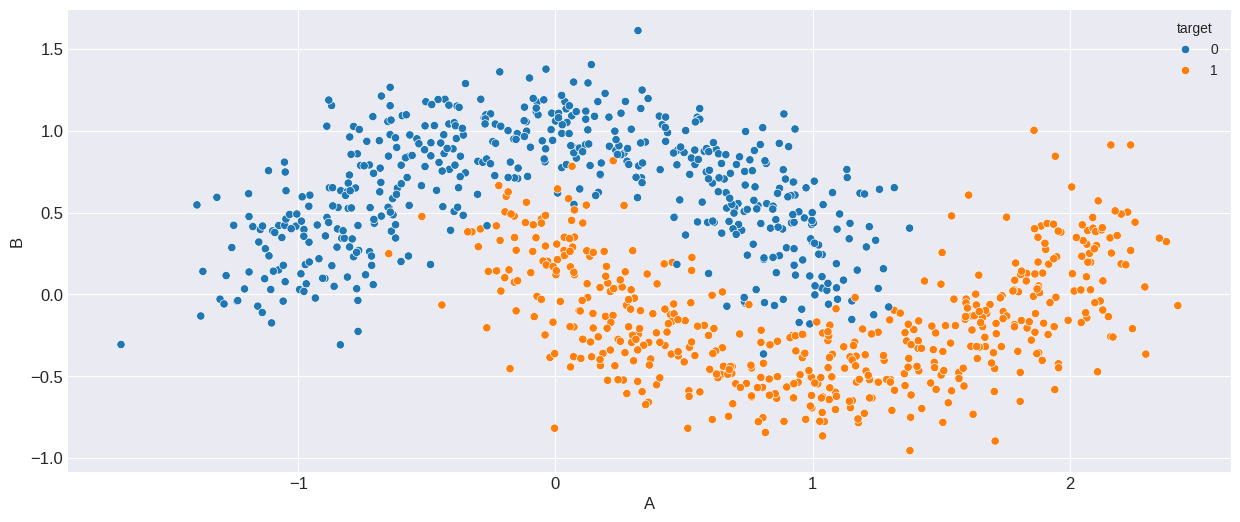

In [10]:
sns.scatterplot(x='A',y='B',data=data_df,hue='target')

<div style="font-family: Arial; font-size:1.2em;">
    We will keep 10%, i.e. 100 records for testing and remaining records will be used in training. Note that the data is already random.
</div>

In [11]:
train_df = data_df.to_numpy()[:-100]
test_df = data_df.to_numpy()[-100:]
train_df.shape , test_df.shape

((900, 3), (100, 3))

# Over to Perceptron

<div style="font-family: Arial; font-size:1.1em;">

Our output is binary. To keep the code in line with what we discussed in the lecture, we will simply output 1 for positive values of 'z' and zero for negative values.
</div>

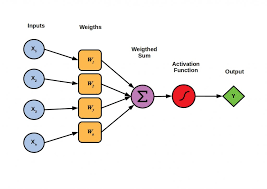


$$
\begin{aligned}
z & = 1.0 \circ w_0 + x_1 \circ w_1 + x_2 \circ w_2 \\
\mathrm{or}\\
z & = X\circ W \\
\end{aligned}
$$
<br/>


$$
\begin{equation*}
    \hat{y} = \begin{cases}
      1.0, & \text{for z>=0}\  \\
      0.0, & \text{for z<0}\
    \end{cases}
\end{equation*}
$$

<div style="font-family: Arial; font-size:1.2em;">
<p>
As we know that adjustments in the weights are (a-$\hat{y}$). We don't want to adjust by full value. It makes convergence easier if we adjust by a small fraction. </p>
    <p><b>Why?</b> We would know better all through this module. We will circle back to learning_rate after some sessions.
<p>Let's assume that adjusting weights by $\alpha$ * ( a - $\hat{y}$ ) makes better sense. </p>
<p>
    <strong>Note:</strong> Take learning_rate ($\alpha$) as some constant.
</p>
</div>

### Sigmoid
 Function

In [12]:
def fn_sigmoid(z):
    return 1/(1+np.exp(-z))


### Tanh
 Function

In [13]:
def fn_actv(z):
    return np.tanh(z)

def fn_actv_prime(a):
    return 1-np.tanh(a)**2

In [14]:
fn_actv(np.array([-1,0,1]))

array([-0.76159416,  0.        ,  0.76159416])

In [15]:
np.tanh(0.5)

0.46211715726000974

## 5. Prediction

In [16]:
# A function to make predictions

def predict(model , X):

    W1, b1, W2, b2 = model['W1'],model['b1'],model['W2'],model['b2']

    # Layer 1

    z1 = X.dot(W1) + b1
    a1 = fn_actv(z1)

    # Layer 2

    z2 = a1.dot(W2) + b2
    a2 = fn_sigmoid(z2)

    return a2 >=0.5 # change for sigmoid function 

**Its advisable to test the function**

In [17]:
def calulate_loss(model , X,y):

    W1, b1, W2, b2 = model['W1'],model['b1'],model['W2'],model['b2']

    m = X.shape[0]

    ####-------------------
    ### Forward Propogation
    ####-------------------

    # Layer 1

    z1 = X.dot(W1) + b1
    a1 = fn_actv(z1)

    # Layer 2

    z2 = a1.dot(W2) + b2
    a2 = fn_sigmoid(z2)

    data_loss = -(y*np.log(a2)).sum()

    return 1./m * data_loss

<div style="font-family: Arial; font-size:1.2em;">
    <h3>Back-propagation - Estimate Perceptron weights </h3>
    $
\begin{aligned}
\partial{z}  & = a - y \\
\partial{b}  & = \partial{z} \\
\partial{w_1}  & = x_1 \circ \partial{z}\\
\partial{w_2}  & = x_2 \circ \partial{z}\\
\end{aligned}
$
    <hr>
      $
\begin{aligned}
b & = b -  \frac{1}{m} (\alpha \circ \partial{b}) \\
w_1  & = w_1 - \frac{1}{m}(\alpha \circ \partial{w_1} )\\
w_2  & = w_2 - \frac{1}{m}(\alpha \circ \partial{w_2} )\\
\end{aligned}
$
    </div>
    
 ## 6. Training

In [18]:
X_train , X_test , y_train, y_test = train_test_split(x,y,
                                                      random_state=RANDOM_STATE,
                                                      stratify=y,
                                                      test_size=TEST_SIZE)
X_train.shape , X_test.shape , y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [19]:
nn_input_dim = X_train.shape[1]
nn_hdim = 4
nn_output_dim = 1

hist = {}

In [20]:
# Function to train the model

def build_model(X,y, alpha = ALPHA , epochs = EPOCHS ):

    W1 = np.random.rand(nn_input_dim, nn_hdim)/np.sqrt(nn_input_dim)
    W2 = np.random.rand(nn_hdim, nn_output_dim)/np.sqrt(nn_hdim)

    b1 = np.zeros((1, nn_hdim))
    b2 = np.zeros((1, nn_output_dim))

    curr_loss = 0

    loss, epoch = [] , []

    m = X.shape[0]

    for i in range(epochs):
        ####----------------------
        #### Forward Propogation
        #### ---------------------

        # layer 1
        z1 = X.dot(W1) + b1 # Agg
        a1 = fn_actv(z1) # Activation

        # layer 2
        z2 = a1.dot(W2) + b2 # Agg
        a2 = fn_sigmoid(z2) # Activation
        # print(a2.shape)


        ####----------------------
        #### Back Propogation
        #### ---------------------

        # layer 2
        dz2 = a2 - y
        assert(z2.shape == dz2.shape) , f'error z2 {z2.shape}/{dz2.shape}'

        dW2 = (a1.T).dot(dz2)
        assert(W2.shape == dW2.shape) , f'error W2 {W2.shape}/{dW2.shape}'

        db2 = np.sum(dz2,axis=0,keepdims=True) # Mantaning dimentions while doing sum
        assert(b2.shape == db2.shape) , f'error b2 {b2.shape}/{db2.shape}'

        da1 = dz2.dot(W2.T)

        # Layer 1

        dz1 = da1 * fn_actv_prime(z1)  # fn_actv_prime = dariavateive of the activatin fuction


        dW1 = (X.T).dot(dz1)
        assert(W1.shape == dW1.shape) , f'error W1 {W1.shape}/{dW1.shape}'

        db1 = np.sum(dz1,axis=0 , keepdims=True)
        assert(b1.shape == db1.shape) , f'error b1 {b1.shape}/{db1.shape}'

        W1 += -alpha * dW1 / m

        W2 += -alpha * dW2 / m

        b1 += -alpha * db1 / m

        b2 += -alpha * db2 / m

        model = {'W1':W1,'b1':b1 , 'W2':W2, 'b2': b2}

        if i %100 == 0:
            curr_loss = calulate_loss(model,X,y)
            loss.append(curr_loss)
            epoch.append(i)
            print(f"epoch: {i}; Current Loss = {curr_loss}")

    hist['loss'] = loss
    hist['epoch']= epoch

    return model

In [21]:
y_train = y_train.reshape(-1,1)
y_train.shape,X_train.shape 

((800, 1), (800, 2))

In [22]:
# calling 'train_weight'

model = build_model(X_train,y_train, ALPHA, EPOCHS)

# print(weights)

epoch: 0; Current Loss = 0.3055226254553293
epoch: 100; Current Loss = 0.2568324862256927
epoch: 200; Current Loss = 0.19626278339701286
epoch: 300; Current Loss = 0.1635147026750434
epoch: 400; Current Loss = 0.15282889241956438
epoch: 500; Current Loss = 0.14921506068957605
epoch: 600; Current Loss = 0.14697773084060436
epoch: 700; Current Loss = 0.1446299417592963
epoch: 800; Current Loss = 0.14168034614540864
epoch: 900; Current Loss = 0.13795281169306375
epoch: 1000; Current Loss = 0.13348755793942046
epoch: 1100; Current Loss = 0.12849733621392276
epoch: 1200; Current Loss = 0.1232719663985846
epoch: 1300; Current Loss = 0.11807279213527988
epoch: 1400; Current Loss = 0.11307737049667868
epoch: 1500; Current Loss = 0.10837849073341022
epoch: 1600; Current Loss = 0.104007294787747
epoch: 1700; Current Loss = 0.09995709609900753
epoch: 1800; Current Loss = 0.09620011416859342
epoch: 1900; Current Loss = 0.09269736678328876
epoch: 2000; Current Loss = 0.08940391041519082
epoch: 2100

<Axes: xlabel='epoch'>

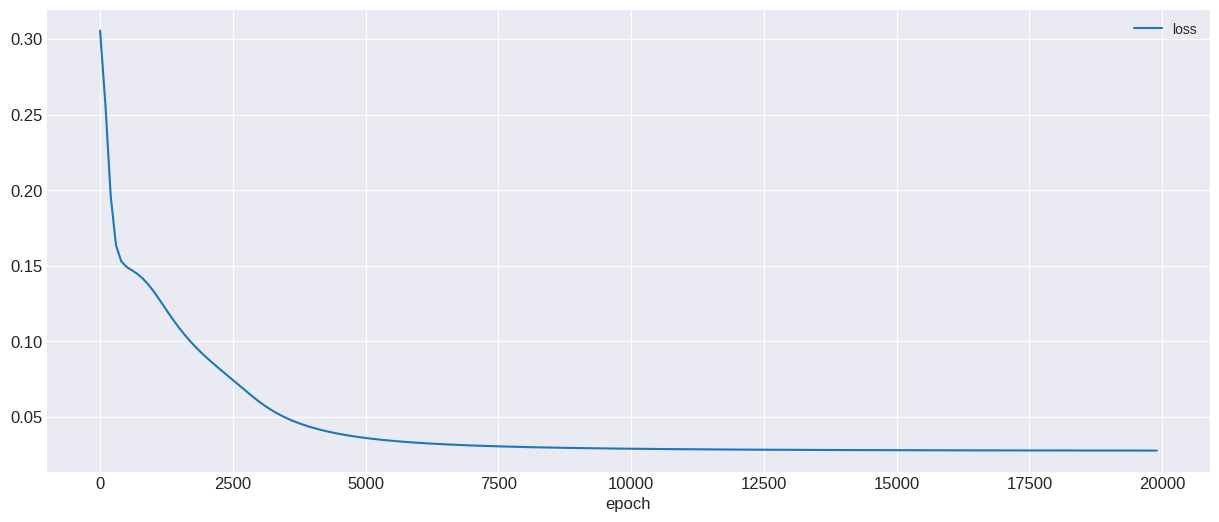

In [23]:
pd.DataFrame(hist).plot(x='epoch')

## Question
<div style="font-family: Arial; font-size:1.2em;">
Why do we keep training and not stop at min training error? Hold on! We would get to that eventually.
</div>

## 7. Predictions

### Train Set

In [24]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :', accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred))
y_pred = predict(model, X_test)

Accuracy score on Train Data : 0.98125
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.98      0.98      0.98       400

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



### Test Set

In [25]:
print('Accuracy score on Test Data :', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy score on Test Data : 0.965
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       100
           1       0.98      0.95      0.96       100

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200



In [26]:
###-----------------------------------
### Function to plot Decision boundary
###-----------------------------------

def fn_plot_decision_boundary(pred_func: Callable[[], np.float64], X_tr: np.ndarray, y_tr: np.ndarray, X_ts :  np.ndarray, y_ts:  np.ndarray,):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X_tr : train feature matrix
           y_tr : train labels
           X_ts : test feature matrix
           y_ts : test labels
       Return:
           None
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X_tr[:, 0].min() - .05, X_tr[:, 0].max() + .05
    yMin, yMax = X_tr[:, 1].min() - .05, X_tr[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    ax = fig.add_axes(111)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP) #, alpha = 0.8
    
    # Plotting scatter for train data
    ax.scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr,
                                  s=30, edgecolor='k', cmap=plt.cm.coolwarm)
    
    
    # Plotting scatter for test data
    ax.scatter(X_ts[:, 0], X_ts[:, 1], c=y_ts,
                                  s=150, marker = '*',edgecolor='k', cmap=plt.cm.inferno )


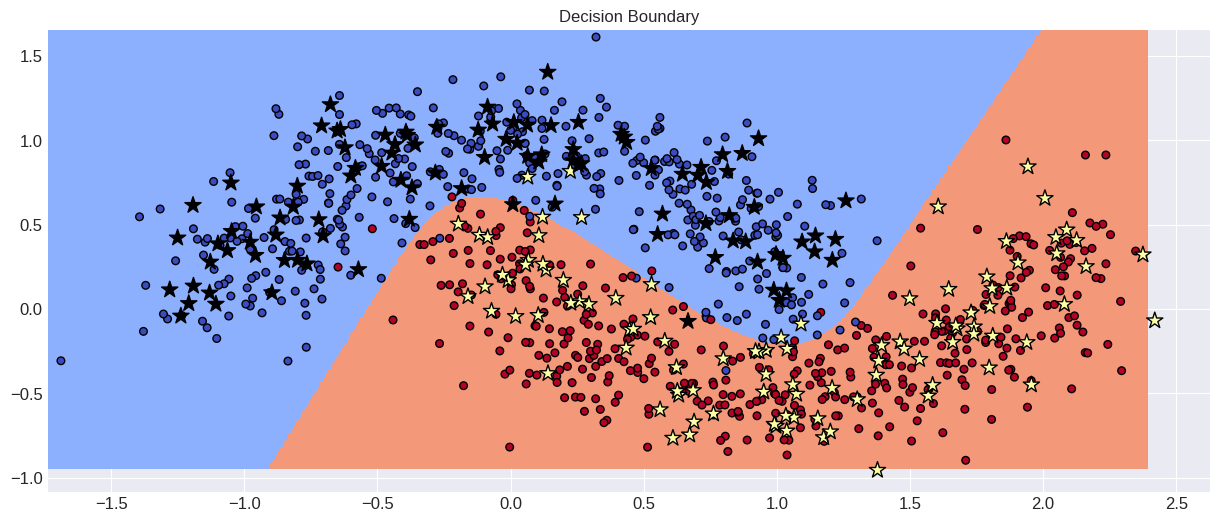

In [27]:
## Plot loss and decision boundary
loss_df = pd.DataFrame(hist)

fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train, X_test, y_test) # plot decision boundary for this plot

plt.title("Decision Boundary");

## Tracking
Lets track the results across various implementations...

 |#|Implementation|Training Accuracy|Testing Accuracy|Remarks|
 |:-:|---|---|---|---|
 |1|Simple Perceptron|0.83111|0.89000||

## Notes:
<img src="../../images/dnn_nb_s03_fig1.png" width='350' align = 'left'>
<img src="../../images/dnn_nb_s03_fig2.png" width='550' align = 'right'>

## A note on Loss Function
<div style="font-family: Arial; font-size:1.2em;">
    <p>In logistic regression we are looking for if it is correct class or not. </p> 
    <p>For example, we want to know if there is a car in the picture or not. So the output is probability of a car in the picture.</p>
    <p><b>Mathematically speaking:</b></p>
    <p>$\hat{y} = p(y=1|x)$ i.e. given training sample $x$, we want to know probability of $y$ being 1.</p>
    <br>
    <p><b>Alternatively:</b></p>
    <p>If there is a car in the picture.  $\Rightarrow$  $y$ = 1 then $p(y|x)$ = $\hat{y}$.</p>
    <p>If there is <b>no</b> car in the picture.$\Rightarrow$ $y$ = 0 then $p(y|x)$ = 1 - $\hat{y}$.</p>
    <br>
    <p>We can summarize two equations as: $p(y|x)$ = $\hat{y}^{y} * (1 - \hat{y}) ^{(1-y)}$</p>
    <p>Above equation is $\hat{y}$ for y = 1 and (1 - $\hat{y}$) for y = 0.</p>
    <p>Taking log of above equation:</p>

$
\begin{aligned}
log [ p(y|x) ] & = log[\hat{y}^{y} * (1 - \hat{y}) ^{(1-y)}]\\
& = y * log(\hat{y}) + (1-y) * log(1 - \hat{y})\\
\end{aligned}
$
<p>Since we aim to minimize above function, add negative sign and our loss function becomes</p>

$
\begin{aligned}
L(\hat{y},y) =  -[y * log\hat{y} + (1-y) * log(1-\hat{y})]\\
\text{or}\\
L(a,y) =  - [ y * log ( a ) + ( 1 - y ) * log( 1 - a ) ]\\
\end{aligned}
$

|Case| y |Loss| a |-log(a)|-log(1-a)|
|:-: |:-:|:-: |:-:|  :-: |   :-:  |
| 1  | 0 | -log( 1 - a )| 0.000001 |13.8155|**1 e-6**|
| 2  | 0 | -log( 1 - a )| 0.999999 |1 e-6|**13.8155**|
| 3  | 1 | -log( a )| 0.000001 |**13.8155**|1 e-6|
| 4  | 1 | -log( a )| 0.999999 |**1 e-6**|13.8155|

</div>

<div style="font-family: Arial; font-size:1.2em;">
    <p>For binary classification the error = - $y * log(a)$</p>
    <p>We want to sum it up for all samples in the dataset. Hence:</p>

$
\begin{aligned}
p(\text{all ys | all rows of x}) & =  \Pi_{i=0}^m p(y|x)\\
log [ p(\text{all ys | all rows of x})] & =  log [ \Pi_{i=0}^m p(y|x) ]\\
& =  \sum_{i=0}^m log [ p(y|x) ] \\
& =  \sum_{i=0}^m [ y * log(\hat{y}) + (1-y) * log(1 - \hat{y}) ]\\
\text{Divide it by m to better scale the costs}\\
& = \frac{1}{m} * \sum_{i=0}^m [ y * log(\hat{y}) + (1-y) * log(1 - \hat{y}) ]\\
\end{aligned}
$

### Introducing $\mathrm{sigmoid}$ function for our binary output.
$$
\begin{aligned}
z & = x_1 . w_1 + x_2 . w_2 + b_1 \\
a & = \hat{y} = \sigma(z)\\
dz & = (a - y) \\
db & = dz\\
b & = b - \alpha . db\\
dw_1 & = x_1. dz\\
dw_2 & = x_2.dz\\
w_1 & = w_1 - \alpha . dw_1\\
w_2 & = w_1 - \alpha . dw_2\\
\end{aligned}
$$
### Sigmoid function
$$
\begin{align}
a &= \sigma(z)\\
&= \dfrac{1}{1 + e^{-z}}\\
\end{align}
$$
    <h3>Derivative of sigmoid function</h3>
$$
\begin{align}
\partial{a} &= \partial{(\sigma(z))}\\
&= \dfrac{\partial}{\partial{z}} \left[ \dfrac{1}{1 + e^{-z}} \right] \\
&= \dfrac{\partial}{\partial{z}} \left( 1 + \mathrm{e}^{-z} \right)^{-1} \\
&= -(1 + e^{-z})^{-2}(-e^{-z}) \\
&= \dfrac{e^{-z}}{\left(1 + e^{-z}\right)^2} \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \dfrac{e^{-z}}{1 + e^{-z}}  \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \dfrac{(1 + e^{-z}) - 1}{1 + e^{-z}}  \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \left[ \dfrac{1 + e^{-z}}{1 + e^{-z}} - \dfrac{1}{1 + e^{-z}} \right] \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \left[ 1 - \dfrac{1}{1 + e^{-z}} \right] \\
&= \sigma(z) \circ (1 - \sigma(z))\\
&= a \circ (1 - a)
\end{align}
$$
    </div>